In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 8)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import h5py as hdf5

In [3]:
class Signal:
    def __init__(self, filename):
        data = hdf5.File(filename)
        self.data = data
        self.detector = data['meta']['Detector'].value.decode()
        self.strain = data['strain']['Strain']
        self.duration = data['meta']['Duration'].value
        self.sampling_rate = self.strain.len() / self.duration
        self.t = np.linspace(0, data['meta']['Duration'].value, self.strain.len())

In [4]:
signals = [
    Signal('data/L-L1_LOSC_CLN_4_V1-1186741845-32.hdf5'),
    Signal('data/H-H1_LOSC_CLN_4_V1-1186741845-32.hdf5'),
    Signal('data/V-V1_LOSC_CLN_4_V1-1186741845-32.hdf5')
]

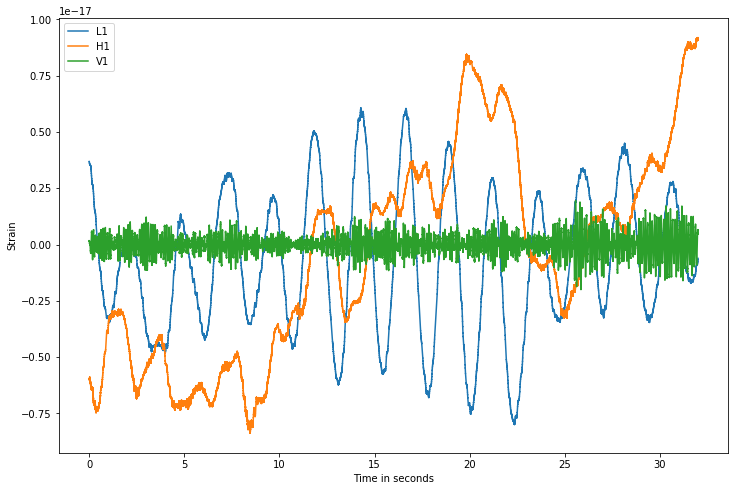

In [5]:
for signal in signals:
    plt.plot(signal.t, signal.strain, label=signal.detector)
plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel("Strain")

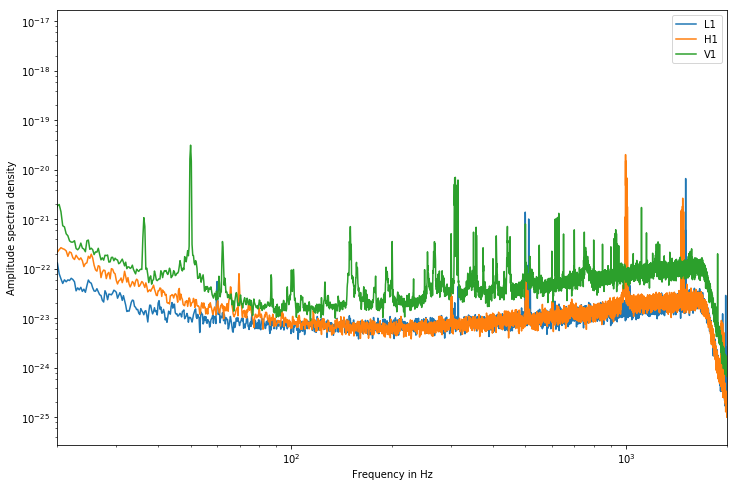

In [6]:
for signal in signals:
    signal.psd, signal.freqs = mpl.mlab.psd(signal.strain, Fs=signal.sampling_rate, NFFT=int(4*signal.sampling_rate))
    plt.loglog(signal.freqs, np.sqrt(signal.psd), label=signal.detector)
plt.xlim(20, 2000)
plt.legend()
plt.ylabel("Amplitude spectral density")
plt.xlabel("Frequency in Hz")

In [7]:
from scipy.interpolate import interp1d

In [8]:
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

In [9]:
fband=[43.0, 300.0]

/Users/knl/.virtualenvs/scientific/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


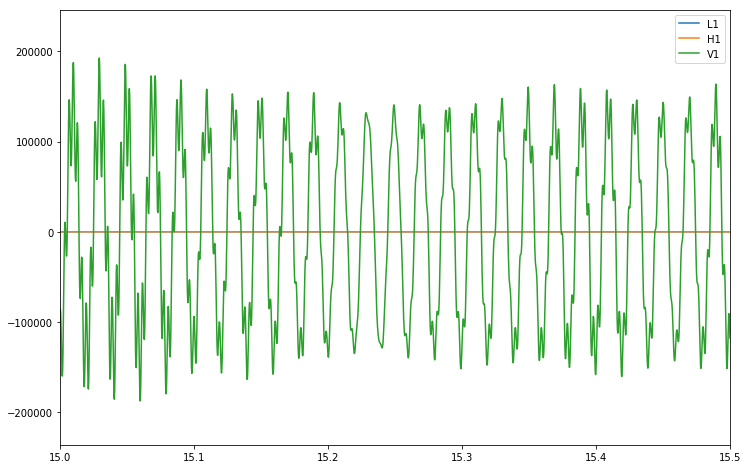

In [10]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht
for signal in signals:
    strain_whitened = whiten(signal.strain, interp1d(signal.freqs, signal.psd), signal.duration)
    bb, ab = butter(4, [fband[0]*2./signal.sampling_rate, fband[1]*2./signal.sampling_rate], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(signal.sampling_rate/2))
    signal.strain_whitened_bp = filtfilt(bb, ab, strain_whitened) / normalization
    plt.plot(signal.t, signal.strain_whitened_bp, label=signal.detector)
plt.xlim(15, 15.5)
plt.legend()